In [1]:
####################Load necessary libraries####################
#%pylab inline

import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

from scipy import stats
from scipy.stats import wilcoxon

#Add personal functions to python path
sys.path.append('/neurospin/meg/meg_tmp/WMP_Darinka_2015/Python')

from jr.plot import base, gat_plot, pretty_gat, pretty_decod
from jr.stats import gat_stats, parallel_stats

%matplotlib inline

/home/dt237143/anaconda2/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/dt237143/anaconda2/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/dt237143/anaconda2/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/dt237143/anaconda2/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from t

In [2]:
def _my_wilcoxon(X):
    out = wilcoxon(X)
    return out[1]

In [3]:
####################Define important variables####################
#Paths
data_path = '/neurospin/meg/meg_tmp/WMP_Darinka_2015/Decoding/IndividualResults/DecVis'
indResult_path = '/neurospin/meg/meg_tmp/WMP_Darinka_2015/Decoding/IndividualResults/DecVis/Figures'
groupResult_path = '/neurospin/meg/meg_tmp/WMP_Darinka_2015/Decoding/GroupResults/DecVis'

#List of parameters
#ListSubject = ['ab140235', 'ad120287', 'ar140056', 'cc140058', 'cf140251', 'eg140204', 
     #'el130086', 'lm130479', 'ma130185', 'ro130031', 'sa130042', 'sb120316', 
     #'th130177', 'ws140212']
ListSubject = ['ab140235', 'ad120287', 'ar140056', 'cc140058', 'eg140204', 
     'el130086', 'lm130479', 'ma130185', 'ro130031', 'sa130042', 'sb120316', 
     'th130177', 'ws140212']
ListCondition = [['Train_P', 'Test_P'], ['Train_WM', 'Test_WM'], ['Train_P', 'Test_WM'], ['Train_WM', 'Test_P']]

chance = 0.5

ttp = [-0.2]
#toi = [0.2, 0.4, 0.6, 0.8, 1.0]
#toi = [0.3, 0.6, 0.9, 1.2, 1.5]
#toi = [0.4, 0.8, 1.2]
toi = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

In [4]:
####################Initialize results####################
all_scores = []
all_diagonals = []

In [5]:
####################Load data####################
for c, cond in enumerate(ListCondition):
    for s, subject in enumerate(ListSubject):
        fname = data_path + '/' + subject + '_' + cond[0] + '_' + cond[1] + '-score.npy'
        score = np.load(fname)
        all_scores.append(score)
        
        fname = data_path + '/' + subject + '_' + cond[0] + '_' + cond[1] + '-diagonal.npy'
        diagonal = np.load(fname)
        all_diagonals.append(diagonal)
    
        fname = data_path + '/' + subject + '_' + cond[0] + '_' + cond[1] + '-time.npy'
        time = np.load(fname)

all_scores = np.array(all_scores) #shape: subjects*n_cond, training_times, testing_times
all_diagonals = np.array(all_diagonals)  

In [6]:
####################Reshape data####################
all_scores = np.reshape(all_scores, (len(ListCondition), len(ListSubject), score.shape[0], score.shape[1])) #n_cond, n_subj, training_times, testing_times
all_diagonals = np.reshape(all_diagonals, (len(ListCondition), len(ListSubject), diagonal.shape[0]))


In [7]:
####################Select subset of time window###################
#Identify the index
ind = np.where(time == ttp[0])
ind = int(ind[0][0])

#Cut all of the data
time = time[ind :]
all_diagonals = all_diagonals[:, :, ind :]
all_scores = all_scores[:, :, ind :, ind :]

In [8]:
####################Compute stats for each condition separately####################
p_values_gat = np.zeros((len(ListCondition), all_scores.shape[2], all_scores.shape[3]))
p_values_gat_fdr = np.zeros((len(ListCondition), all_scores.shape[2], all_scores.shape[3]))
p_values_diagonal = np.zeros((len(ListCondition), all_diagonals.shape[2]))
p_values_diagonal_fdr = np.zeros((len(ListCondition), all_diagonals.shape[2]))

for c, cond in enumerate(ListCondition):
    p_values_gat[c, :, :] = parallel_stats(all_scores[c, :, :, :] - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
    p_values_gat_fdr[c, :, :] = parallel_stats(all_scores[c, :, :, :] - chance, function = _my_wilcoxon, correction = 'FDR', n_jobs = -1)
    p_values_diagonal[c, :] = parallel_stats(all_diagonals[c, :, :] - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
    p_values_diagonal_fdr[c, :] = parallel_stats(all_diagonals[c, :, :] - chance, function = _my_wilcoxon, correction = 'FDR', n_jobs = -1)

    #Get one-sided p-value
    p_values_diagonal[c, :] = p_values_diagonal[c, :]/2.
    p_values_diagonal_fdr[c, :] = p_values_diagonal_fdr[c, :]/2.

[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   31.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   30.5s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   31.3s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   30.5s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   31.0s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   31.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   30.6s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   30.5s finished
[Paral

In [9]:
####################Compute stats for each classifier and each condition separately changing the time window for the fdr correction####################
p_values_classifiers = np.zeros((len(ListCondition), len(toi), all_diagonals.shape[2]))
p_values_classifiers_fdr = np.zeros((len(ListCondition), len(toi), all_diagonals.shape[2]))

for c, cond in enumerate(ListCondition):
    for t, tp in enumerate(toi):
        #Identify the index
        ind = np.where(time == toi[t])
        ind = int(ind[0][0])
        startTime = np.where(time == 0.5)
        startTime = int(startTime[0][0])
        endTime = np.where(time == 1.5)
        endTime = int(endTime[0][0])
        p_values_classifiers[c, t, :] = parallel_stats(all_scores[c, :, ind, :] - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
        p_values_classifiers_fdr[c, t, :] = parallel_stats(all_scores[c, :, ind, :] - chance, function = _my_wilcoxon, correction = 'FDR', n_jobs = -1, startTime = startTime, endTime = endTime)


[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

In [10]:
####################Compute stats for each classifier and each condition separately averaging across multiple timepoints####################
p_values_classifiersAvg = np.zeros((len(ListCondition), len(toi), all_diagonals.shape[2]))
p_values_classifiersAvg_fdr = np.zeros((len(ListCondition), len(toi), all_diagonals.shape[2]))

for c, cond in enumerate(ListCondition):
    for t, tp in enumerate(toi):
        #Identify the index
        ind = np.where(time == toi[t])
        ind = int(ind[0][0])
        p_values_classifiersAvg[c, t, :] = parallel_stats(np.mean(all_scores[c, :, ind-3 :ind + 4, :], 1) - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
        p_values_classifiersAvg_fdr[c, t, :] = parallel_stats(np.mean(all_scores[c, :, ind-3 : ind+4, :], 1) - chance, function = _my_wilcoxon, correction = 'FDR', n_jobs = -1)


[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.1s finished
[Paral

In [7]:
####################Compute group averages####################
group_scores = np.zeros((len(ListCondition), all_scores.shape[2], all_scores.shape[3]))
sem_group_scores = np.zeros((len(ListCondition), all_scores.shape[2], all_scores.shape[3]))
group_diagonal = np.zeros((len(ListCondition), all_diagonals.shape[2]))
sem_group_diagonal = np.zeros((len(ListCondition), all_diagonals.shape[2]))

for c, cond in enumerate(ListCondition):
    group_scores[c, :, :] = np.mean(all_scores[c, :, :, :], 0)
    sem_group_scores[c, :, :] = stats.sem(all_scores[c, :, :, :], 0)

    group_diagonal[c, :] = np.mean(all_diagonals[c, :, :], 0)
    sem_group_diagonal[c, :] = stats.sem(all_diagonals[c, :, :], 0)

In [12]:
####################Compute group averages for each classifier####################
group_classifier = np.zeros((len(ListCondition), len(toi), all_diagonals.shape[2]))
sem_group_classifier = np.zeros((len(ListCondition), len(toi), all_diagonals.shape[2]))

for c, cond in enumerate(ListCondition):
    for t, tp in enumerate(toi):
        #Identify the index
        ind = np.where(time == toi[t])
        ind = int(ind[0][0])
        group_classifier[c, t, :] = np.mean(all_scores[c, :, ind, :], 0)
        sem_group_classifier[c, t, :] = stats.sem(all_scores[c, :, ind, :], 0)

In [13]:
####################Compute group averages for each classifier averaging across multiple time points####################
group_classifierAvg = np.zeros((len(ListCondition), len(toi), all_diagonals.shape[2]))
sem_group_classifierAvg = np.zeros((len(ListCondition), len(toi), all_diagonals.shape[2]))

for c, cond in enumerate(ListCondition):
    for t, tp in enumerate(toi):
        #Identify the index
        ind = np.where(time == toi[t])
        ind = int(ind[0][0])
        group_classifierAvg[c, t, :] = np.mean(np.mean(all_scores[c, :, ind-3 : ind+4, :], 1), 0)
        sem_group_classifierAvg[c, t, :] = stats.sem(np.mean(all_scores[c, :, ind-3 : ind+4, :], 1))

In [14]:
####################Compute group averages for each classifier averaging across multiple testing time points####################
n_bins = 6 #to account for baseline period as well
timeBins = [[-0.2, 0], [0, 0.5], [0.5, 1.0], [1.0, 1.5], [1.5, 2.0], [2.0, 2.5]]

#Identify the indices for these timeBins
indBins = np.zeros((len(timeBins), 2))
for t, tp in enumerate(timeBins):
    beg = np.where(time == timeBins[t][0])
    end = np.where(time == timeBins[t][1])
    beg = int(beg[0][0])
    end = int(end[0][0])
    
    indBins[t, 0] = beg
    indBins[t, 1] = end
                        
all_scores_avTestT = np.zeros((len(ListCondition), len(ListSubject), all_scores[0, 0, :, :].shape[1], n_bins))

for c, cond in enumerate(ListCondition):
    for s, subject in enumerate(ListSubject):
        for b, bins in enumerate(indBins):
            all_scores_avTestT[c, s, :, b] = np.mean(all_scores[c, s, :, (bins[0]) : (bins[1] + 1)], 1)


/home/dt237143/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [15]:
####################Compute group averages for each classifier averaging across multiple testing time points####################
group_classifierAvg_TestT = np.zeros((len(ListCondition), all_scores_avTestT.shape[2], all_scores_avTestT.shape[3]))
sem_group_classifierAvg_TestT = np.zeros((len(ListCondition), all_scores_avTestT.shape[2], all_scores_avTestT.shape[3]))

for c, cond in enumerate(ListCondition):
        group_classifierAvg_TestT[c, :, :] = np.mean(all_scores_avTestT[c, :, :, :], 0)
        sem_group_classifierAvg_TestT[c, :, :] = stats.sem(all_scores_avTestT[c, :, :, :], 0)

/home/dt237143/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:90: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/dt237143/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:667: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


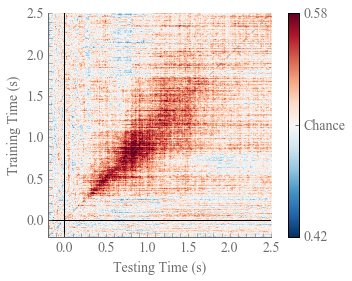

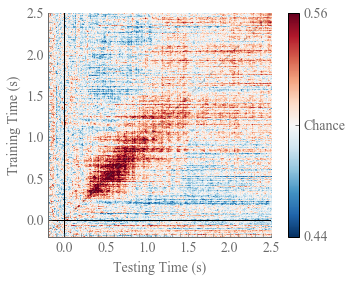

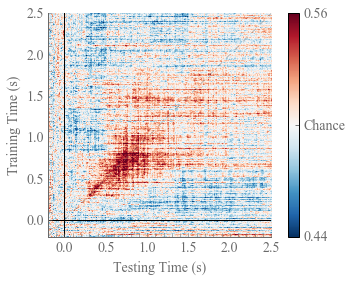

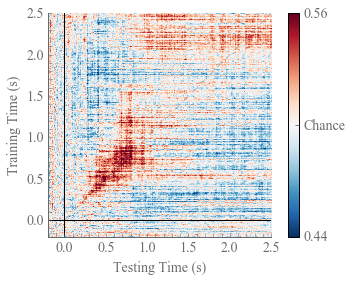

In [9]:
####################Plot original GAT####################
for c, cond in enumerate(ListCondition):
    pretty_gat(group_scores[c, :, :], times = time, chance = chance, ax = None, sig = None, cmap = 'RdBu_r',
             clim = None, colorbar = True, xlabel = 'Testing Time (s)', 
             ylabel = 'Training Time (s)', sfreq = 250, diagonal = 'dimgray', test_times = None, smoothWindow=0)
    plt.show()

/home/dt237143/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:90: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/dt237143/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:667: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


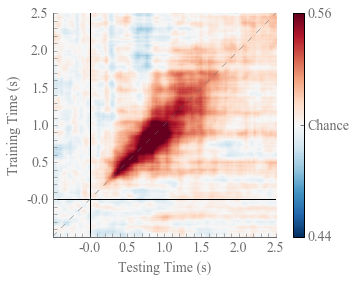

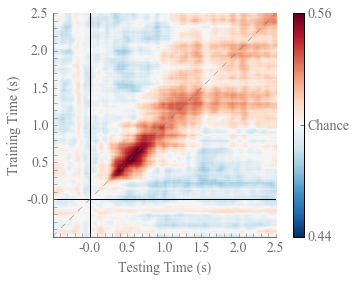

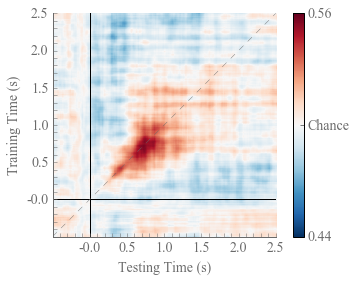

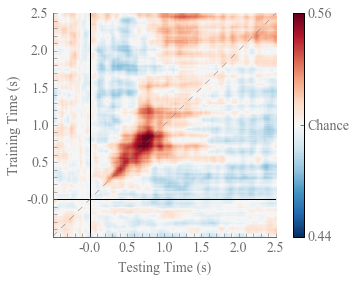

In [8]:
##### Plot GAT with uncorrected p values####################
for c, cond in enumerate(ListCondition):
    classLines = [None, None, toi, toi]
    pretty_gat(group_scores[c, :, :], times = time, chance = chance, ax = None, sig = None, cmap = 'RdBu_r',
             clim = [0.44, 0.56], colorbar = True, xlabel = 'Testing Time (s)', 
             ylabel = 'Training Time (s)', sfreq = 250, diagonal = 'dimgray', test_times = None, smoothWindow=10)
    fname = groupResult_path + '/' + cond[0] + '_' + cond[1] + '-uncorrectedGAT.tif'
    plt.savefig(fname, format = 'tif', dpi = 300, bbox_inches = 'tight')
    plt.show()

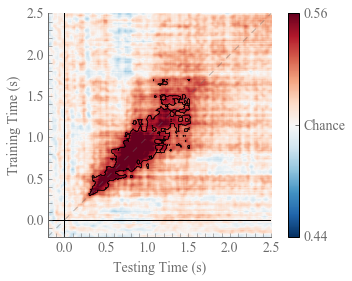

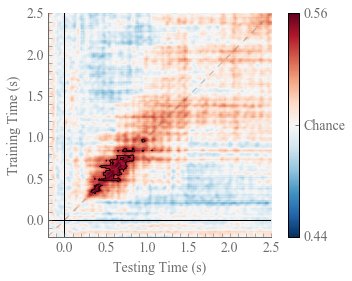

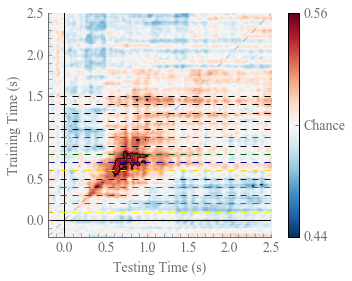

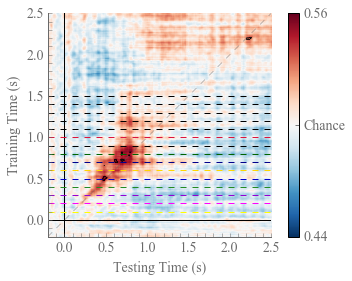

In [18]:
##### Plot GAT with uncorrected p values####################
for c, cond in enumerate(ListCondition):
    classLines = [None, None, toi, toi]
    pretty_gat(group_scores[c, :, :], times = time, chance = chance, ax = None, sig = None, cmap = 'RdBu_r',
             clim = [0.44, 0.56], colorbar = True, xlabel = 'Testing Time (s)', 
             ylabel = 'Training Time (s)', sfreq = 250, diagonal = 'dimgray', test_times = None, smoothWindow=10, 
              classLines = classLines[c], classColors = ['yellow', 'fuchsia', 'darkviolet', 'forestgreen', 'mediumblue', 'gold', 'darkblue', 'darkgreen', 'k', 'crimson', 'k', 'k', 'k', 'k', 'k'])
    fname = groupResult_path + '/' + cond[0] + '_' + cond[1] + '-uncorrectedGAT.tif'
    plt.savefig(fname, format = 'tif', dpi = 300, bbox_inches = 'tight')
    plt.show()

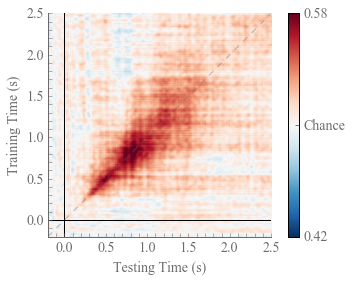

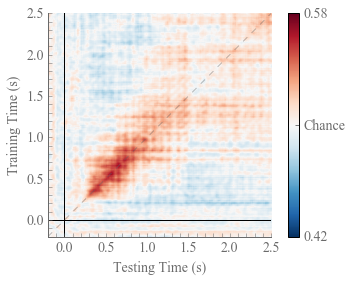

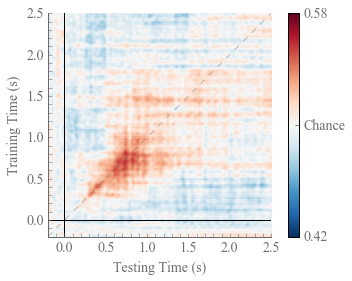

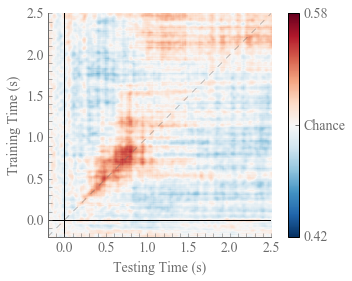

In [19]:
####################Plot GAT with corrected p values####################
for c, cond in enumerate(ListCondition):
    pretty_gat(group_scores[c, :, :], times = time, chance = chance, ax = None, sig = p_values_gat_fdr[c, :, :], cmap = 'RdBu_r',
             clim = [0.42, 0.58], colorbar = True, xlabel = 'Testing Time (s)', 
             ylabel = 'Training Time (s)', sfreq = 250, diagonal = 'dimgray', test_times = None, smoothWindow=5)
    plt.show()

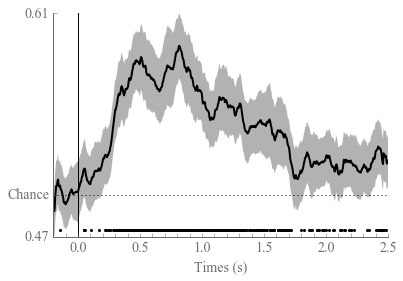

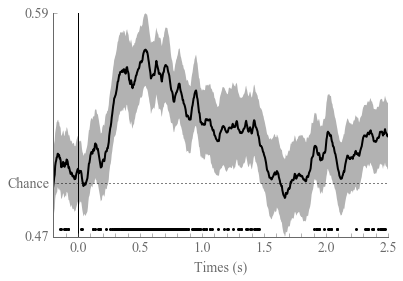

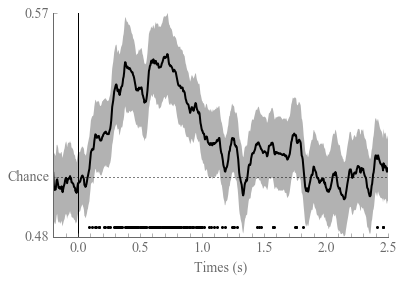

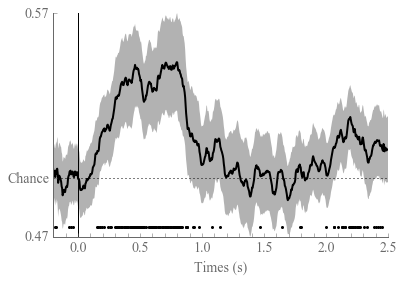

In [20]:
####################Plot decoding with uncorrected p values####################
#colors = ['dodgerblue', 'darkturquoise', 'darkred', 'crimson']
for c, cond in enumerate(ListCondition):
    pretty_decod(all_diagonals[c, :, :], times=time, chance=0.5, ax=None, sig=p_values_diagonal[c, :], width=3.,
                 color='k', fill=False, xlabel='Times (s)', sfreq=250, alpha=.05, scat=False, line=True, smoothWindow=10)
    plt.show()

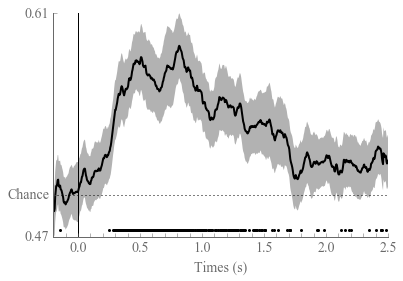

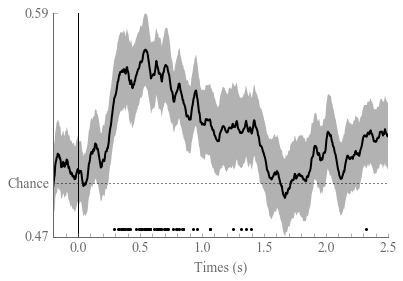

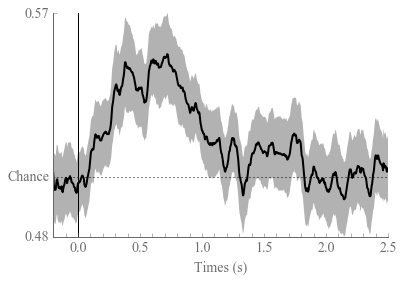

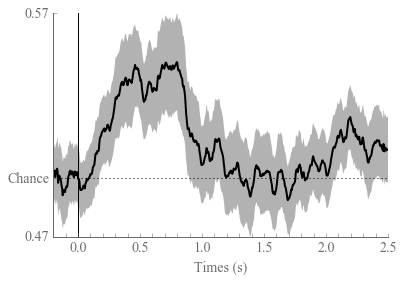

In [21]:
####################Plot decoding with corrected p values####################
#colors = ['dodgerblue', 'darkturquoise', 'darkred', 'crimson']
for c, cond in enumerate(ListCondition):
    pretty_decod(all_diagonals[c, :, :], times=time, chance=0.5, ax=None, sig=p_values_diagonal_fdr[c, :], width=3.,
                 color='k', fill=False, xlabel='Times (s)', sfreq=250, alpha=.05, scat=False, line=True, smoothWindow=10)
    plt.show()

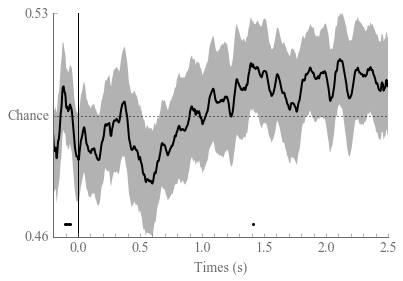

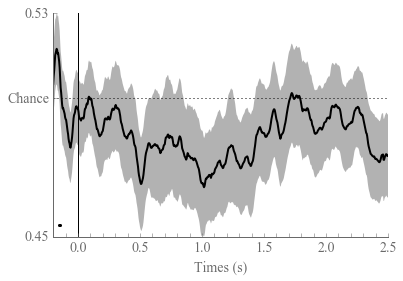

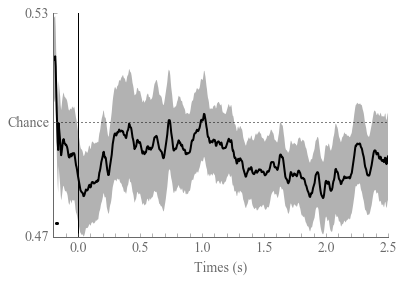

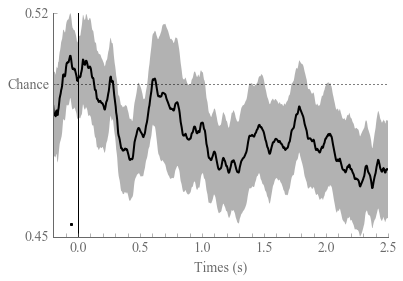

In [22]:
####################Plot decoding with corrected p values####################
for c, cond in enumerate(ListCondition):
    #Identify the index
    ind = np.where(time == toi[0])
    ind = int(ind[0][0])
    pretty_decod(all_scores[c, :, ind, :], times=time, chance=0.5, ax=None, sig=p_values_classifiers[c, 0, :], width=3.,
                 color='k', fill=False, xlabel='Times (s)', sfreq=250, alpha=.05, scat=False, line=True, smoothWindow=10)
    plt.show()

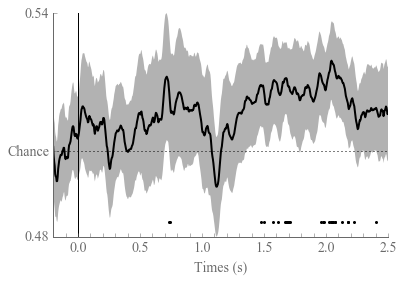

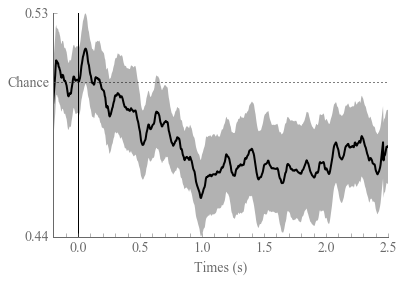

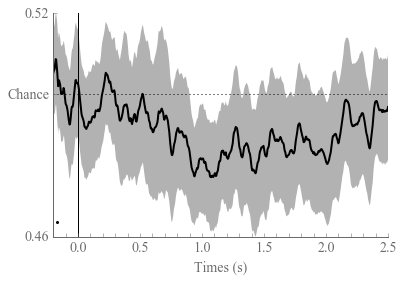

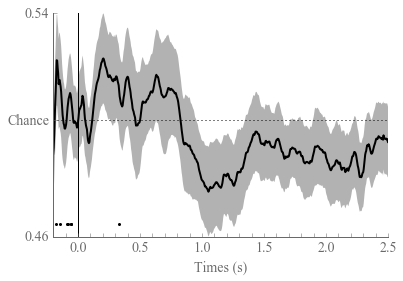

In [23]:
####################Plot decoding with corrected p values####################
#colors = ['dodgerblue', 'darkturquoise', 'darkred', 'crimson']
for c, cond in enumerate(ListCondition):
    #Identify the index
    ind = np.where(time == toi[1])
    ind = int(ind[0][0])
    pretty_decod(all_scores[c, :, ind, :], times=time, chance=0.5, ax=None, sig=p_values_classifiers[c, 1, :], width=3.,
                 color='k', fill=False, xlabel='Times (s)', sfreq=250, alpha=.05, scat=False, line=True, smoothWindow=10)
    plt.show()

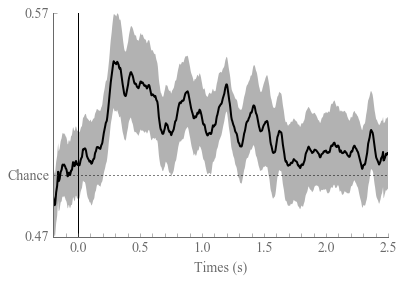

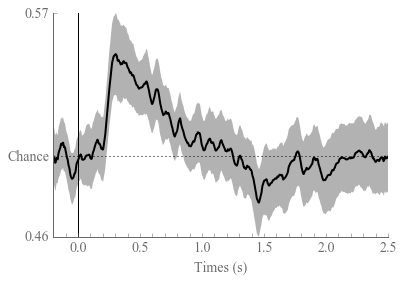

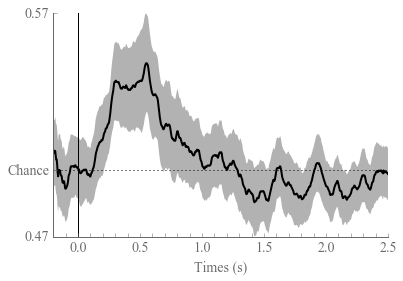

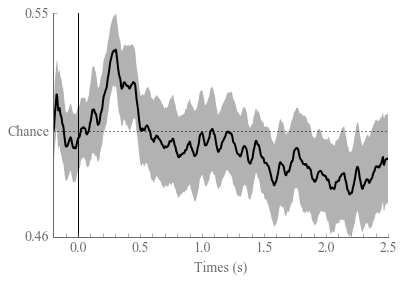

In [24]:
####################Plot decoding with corrected p values####################
#colors = ['dodgerblue', 'darkturquoise', 'darkred', 'crimson']
for c, cond in enumerate(ListCondition):
    #Identify the index
    ind = np.where(time == toi[2])
    ind = int(ind[0][0])
    pretty_decod(all_scores[c, :, ind, :], times=time, chance=0.5, ax=None, sig=p_values_classifiers_fdr[c, 2, :], width=3.,
                 color='k', fill=False, xlabel='Times (s)', sfreq=250, alpha=.05, scat=False, line=True, smoothWindow=10)
    plt.show()

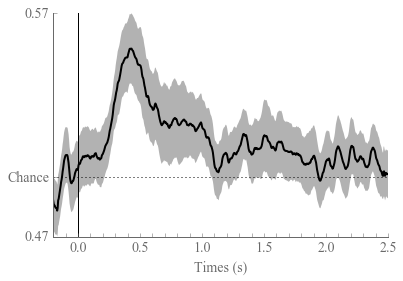

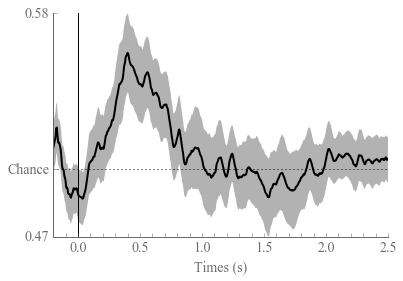

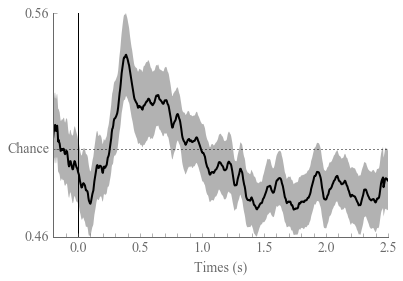

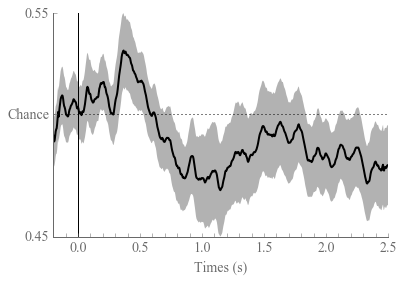

In [25]:
####################Plot decoding with corrected p values####################
#colors = ['dodgerblue', 'darkturquoise', 'darkred', 'crimson']
for c, cond in enumerate(ListCondition):
    #Identify the index
    ind = np.where(time == toi[3])
    ind = int(ind[0][0])
    pretty_decod(all_scores[c, :, ind, :], times=time, chance=0.5, ax=None, sig=p_values_classifiers_fdr[c, 3, :], width=3.,
                 color='k', fill=False, xlabel='Times (s)', sfreq=250, alpha=.05, scat=False, line=True, smoothWindow=10)
    plt.show()

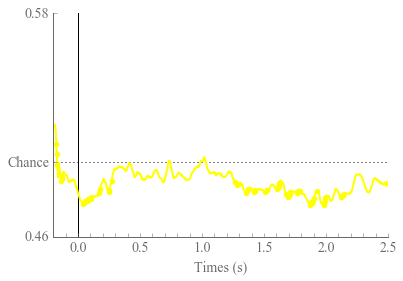

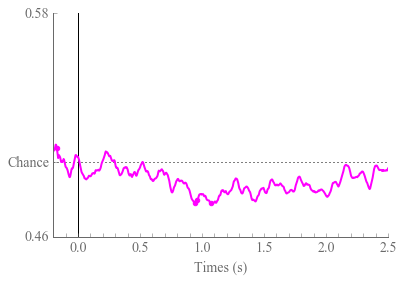

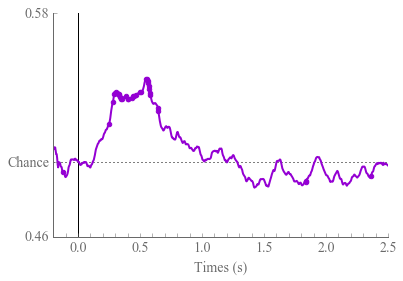

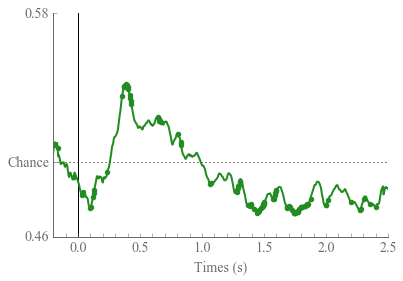

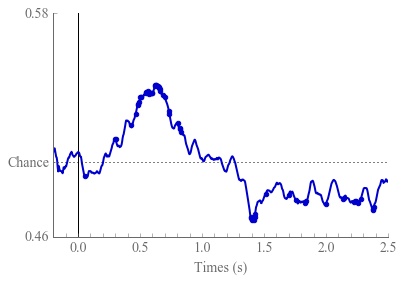

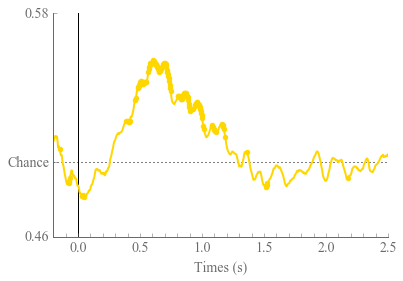

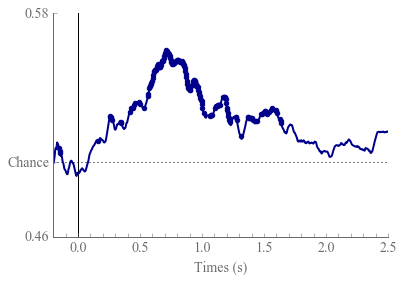

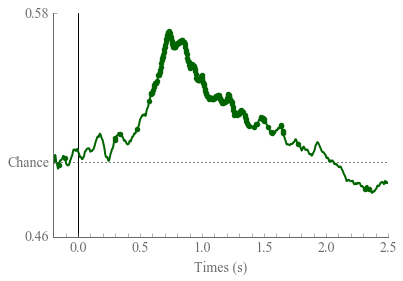

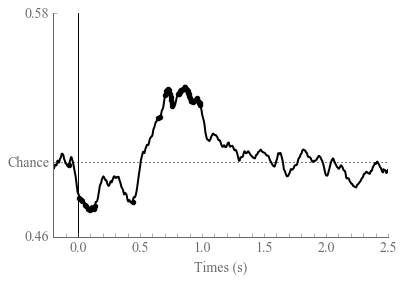

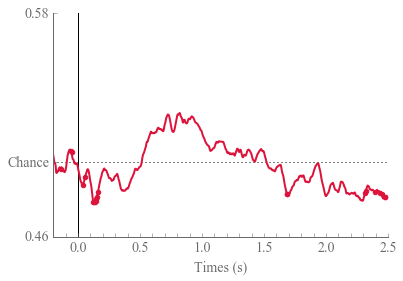

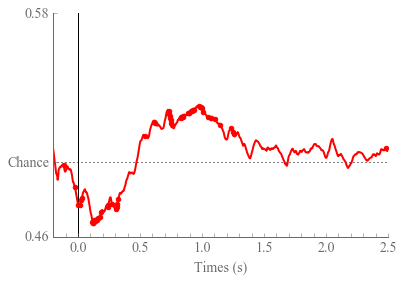

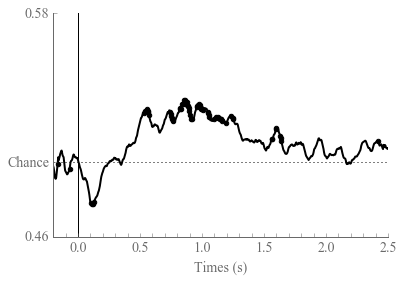

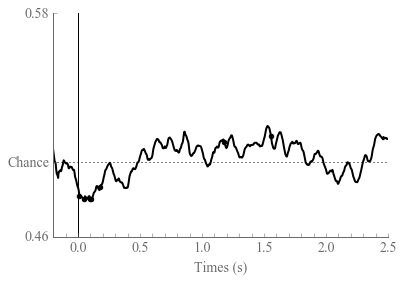

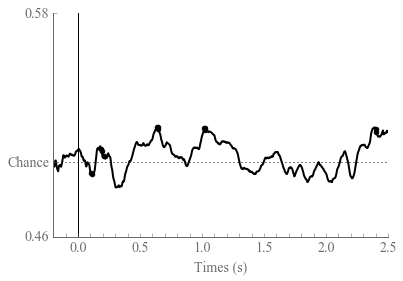

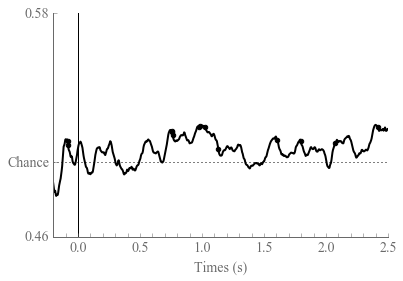

In [26]:
####################Plot decoding with corrected p values####################
classColors = ['yellow', 'fuchsia', 'darkviolet', 'forestgreen', 'mediumblue', 'gold', 'darkblue', 'darkgreen', 'k', 'crimson', 'red', 'k', 'k', 'k', 'k', 'k']
for t, tp in enumerate(toi):
    #Identify the index
    ind = np.where(time == toi[t])
    ind = int(ind[0][0])
    pretty_decod(group_classifier[2, t, :], times=time, chance=0.5, ax=None, sig=p_values_classifiers[2, t, :], width=3.,
                 color=classColors[t], fill=False, xlabel='Times (s)', sfreq=250, alpha=.05, scat=True, line=False, smoothWindow=10, lim=[0.46, 0.58])
    plt.show()

In [ ]:
####################Plot decoding with corrected p values####################
classColors = ['yellow', 'fuchsia', 'darkviolet', 'forestgreen', 'mediumblue', 'gold', 'darkblue', 'darkgreen', 'k', 'crimson', 'red', 'k', 'k', 'k', 'k', 'k']
for t, tp in enumerate(toi):
    #Identify the index
    ind = np.where(time == toi[t])
    ind = int(ind[0][0])
    pretty_decod(group_classifier[3, t, :], times=time, chance=0.5, ax=None, sig=p_values_classifiers[3, t, :], width=3.,
                 color=classColors[t], fill=False, xlabel='Times (s)', sfreq=250, alpha=.05, scat=True, line=False, smoothWindow=10, lim=[0.46, 0.58])
    plt.show()

In [ ]:
####################Plot decoding with corrected p values####################
classColors = ['yellow', 'fuchsia', 'darkviolet', 'forestgreen', 'mediumblue', 'gold', 'darkblue', 'darkgreen', 'k', 'crimson', 'red', 'k', 'k', 'k', 'k', 'k']
for t, tp in enumerate(toi):
    #Identify the index
    ind = np.where(time == toi[t])
    ind = int(ind[0][0])
    pretty_decod(group_classifier[2, t, :], times=time, chance=0.5, ax=None, sig=p_values_classifiers_fdr[2, t, :], width=3.,
                 color=classColors[t], fill=False, xlabel='Times (s)', sfreq=250, alpha=.05, scat=True, line=False, smoothWindow=10, lim=[0.46, 0.58])
    plt.show()

In [ ]:
####################Plot decoding with corrected p values####################
classColors = ['yellow', 'fuchsia', 'darkviolet', 'forestgreen', 'mediumblue', 'gold', 'darkblue', 'darkgreen', 'k', 'crimson', 'red', 'k', 'k', 'k', 'k', 'k']
for t, tp in enumerate(toi):
    #Identify the index
    ind = np.where(time == toi[t])
    ind = int(ind[0][0])
    pretty_decod(group_classifierAvg[2, t, :], times=time, chance=0.5, ax=None, sig=p_values_classifiersAvg_fdr[2, t, :], width=3.,
                 color=classColors[t], fill=False, xlabel='Times (s)', sfreq=250, alpha=.05, scat=True, line=False, smoothWindow=10, lim=[0.46, 0.58])
    plt.show()

In [ ]:
####################Plot decoding with corrected p values####################
classColors = ['yellow', 'fuchsia', 'darkviolet', 'forestgreen', 'mediumblue', 'gold', 'darkblue', 'darkgreen', 'k', 'crimson', 'red', 'k', 'k', 'k', 'k', 'k']
for t, tp in enumerate(toi):
    #Identify the index
    ind = np.where(time == toi[t])
    ind = int(ind[0][0])
    pretty_decod(group_classifier[3, t, :], times=time, chance=0.5, ax=None, sig=p_values_classifiers[3, t, :], width=3.,
                 color=classColors[t], fill=False, xlabel='Times (s)', sfreq=250, alpha=.05, scat=True, line=False, smoothWindow=10, lim=[0.46, 0.58])
    plt.show()

In [ ]:
from mne.stats import fdr_correction

In [ ]:
timeBins

In [ ]:
group_classifierAvg_TestT.shape

In [ ]:
sem_group_classifierAvg_TestT.shape

In [ ]:
####################Plot decoding in time bins####################

#Load important libraries
import matplotlib.pyplot as plt

#Define important variables
font = {'fontname': 'Times New Roman', 'fontsize': 14}

colors_blind = [(0.0, 0.4470588235294118, 0.6980392156862745),
                 (0.0, 0.6196078431372549, 0.45098039215686275),
                 (0.8352941176470589, 0.3686274509803922, 0.0),
                 (0.8, 0.4745098039215686, 0.6549019607843137),
                 (0.9411764705882353, 0.8941176470588236, 0.25882352941176473),
                 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
               (0.0, 0.4470588235294118, 0.6980392156862745),
               (0.0, 0.6196078431372549, 0.45098039215686275),
                (0.8352941176470589, 0.3686274509803922, 0.0),]

xLabels = ['Baseline', '0.0 - 0.5s', '0.5 - 1.0s', '1.0 - 1.5s', '1.5 - 2.0s', '2.0 - 2.5s']

x = np.arange(n_bins)
index = np.arange(n_bins)

for c, cond in enumerate(ListCondition[2:]):
    for train, trainT in enumerate(toi):
        ax = plt.gca()
        #Identify the index
        ind = np.where(time == toi[train])
        ind = int(ind[0][0])
        print(cond, trainT)
        ax.bar(x, group_classifierAvg_TestT[c, ind, :], alpha = 0.8, color = colors_blind)
        for pos, y, err, color in zip(x, group_classifierAvg_TestT[c, ind, :], sem_group_classifierAvg_TestT[c, ind, :], colors_blind):
            ax.errorbar(pos + 0.4, y, err, lw = 2, capsize = 5, color = color)
        
        #Plot chance level
        plt.axhline(0.5, color = 'k', ls = '--')

        #Take care of axes
        ax.margins(0.05) #spacing at the 
        ax.set_xticks(index + 0.4)
        ax.set_xticklabels(xLabels)
        ax.set_ylim([0.4, 0.6])
        plt.show()